# Part of my portfolio, complete report can be read at http://zohaibdr.github.io 

# Dataset

The data contains information on web sessions of an online merchant:

--------------------------------------
### The first 6 columns
- **"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration"**: These represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories.
- The values of these features are derived from the URL information of the pages visited by the user and updated in real-time when a user takes an action, e.g. moving from one page to another.
--------------------------------------
### The next 3 columns
- The **"Bounce Rate", "Exit Rate" and "Page Value"** features represent the metrics measured by "Google Analytics" for each page in the e-commerce site.
- **Bounce Rate** for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

- **Exit Rate** for a specific web page is calculated as for all pageviews to the page, the percentage that was the last in the session.

- Dataset has average bounce rates and exit rates for a page customer landed on.

Read more about **Bounce Rate** vs **Exit Rate** [here](https://support.google.com/analytics/answer/2525491?hl=en&ref_topic=6156780)
- **Page Value** represents the average value for a web page that a user visited before completing an e-commerce transaction.

Read more about **Page Value** [here](https://support.google.com/analytics/answer/2695658?hl=en).

--------------------------------------
### Remaining columns
- **Special Day:** The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with the transaction.
- The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date.
- For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.
-------------------------------------- 
- The dataset also includes the operating system, browser, region, traffic type.
- VisitorType: returning visitor, new visitor, or other types of customer. 
- Weekend: a Boolean value indicating whether the date of the visit is weekend or not 
- Month: month of the year

### The target variable 
- Finally, the 'Revenue' variable indicates whether the customer made a purchase or not (TRUE/FALSE). 

In [2]:
# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")
# %load_ext nb_black

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
# pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
# pd.set_option("display.max_rows", 200)

# Libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report,
    make_scorer,
)


In [3]:
# read the data 
data = pd.read_csv("intention_data.csv")
# data.tail().T

# auto EDA 

In [4]:
# %pip install -U ydata-profiling  #requires python <3.11 so run in 3.9 
from ydata_profiling import ProfileReport
#https://ydata-profiling.ydata.ai/docs/master/pages/getting_started/quickstart.html

# profile = ProfileReport(data, title="Pandas Profiling Report")

# #Save profile report to a file for easy analysis, rather than displaying here 
# profile.to_file("profile_report.html") 

In [5]:
# Similar analysis can be done with another library, Sweetviz. 
# This one is more lightweight 

# %pip install sweetviz
# https://pypi.org/project/sweetviz/

import sweetviz as sv
viz_report = sv.analyze(data, target_feat="Revenue", pairwise_analysis="on")

viz_report.show_html(layout='vertical') #Default arguments will generate to "SWEETVIZ_REPORT.html"

#embed an IFRAME element showing the report right inside a notebook
# viz_report.show_notebook() 

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Insights:
- Most of the data-types are either **int64** or **float64**.
- 2 columns - Month and VisitorType are having data-types as an **object**, this means we need to convert these into suitable data-type before we feed our data into the model.
The last two columns: "Weekend" and "Revenue", have the data-type as a **bool**.
- VisitorType is highly imbalanced (59.9%) 
- Several variables have significant number of zero values

* Most of the variables are right-skewed.
* 75% of customers stay less than 93 seconds on Administrative pages in a session.
* Very few customers have visited the informational page.
* From those who do, on average, customers have spent 35 seconds on the informational page.
* On average customers have spent 1194 seconds (~20 minutes) on the 'ProductRelated' page which is way more than the administrative page and informational page. 
* The Median duration for product pages is 599 seconds (~10 minutes). 75% customers spend less than 1464 seconds (~24 mintues). 
* On average the bounce rate of a webpage is 0.022.
* On average the bounce rate of a webpage is 0.043.

## Analyzing Categorical Columns

In [6]:
cat_columns = ["Month", "VisitorType", "Weekend", "Revenue"]
for i in cat_columns:
    print(data[i].value_counts())
    print("*" * 50)

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64
**************************************************
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64
**************************************************
False    9462
True     2868
Name: Weekend, dtype: int64
**************************************************
False    10422
True      1908
Name: Revenue, dtype: int64
**************************************************


### Analysis on Categorical columns 

* Data is of 10 months January and April's data is not available with us.
* Overall, only about 15% of all visitors make a purchase.
* Over 85% of visitors are returning visitors, only under 14% are new visitors which is good for the business
* Most number of visitors visited in May (27.3%), followed by November (24.3%) and March (15.5%). 
* The coversion rate is the highest in November (25% make a purchase). 
* Most traffic on the website is generally on the weekdays.
* Website is only able to generate revenue from a small portion of customers.

## From SweetViz, Going a step further 
* Despite being smaller in proportion, new visitors are more likely to make a purchase (25%) than returning visitors (14%).
* Most purchases are made on the weekdays (77%). Weekends account for only 22% of all purchases. 
* However, customers are more likely to make a purchase on weekends (17%) than on weekdays (15%). 

## Data Preparation

In [7]:
# dropping PageValues 
# PageValues column has information related to the transaction activity of a customer and would create a bias in model if used in prediction. So, we will drop it.
data = data.drop(["PageValues"], axis=1)

# Convert Categorical variables into dummy or indicator variables

# creating dummy varibles
dummy_data = pd.get_dummies(
    data,
    columns=[
        "Month",
        "VisitorType",
        "Weekend",
        "Region",
        "Browser",
        "OperatingSystems",
        "SpecialDay",
    ],
    drop_first=True,
)
dummy_data.head()



,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,TrafficType,Revenue,...,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,1,False,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,2,False,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,3,False,...,1,0,0,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,4,False,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,4,False,...,0,0,0,0,0,0,0,0,0,0


## Split data

In [8]:
X = dummy_data.drop("Revenue", axis=1)  # Features
y = dummy_data["Revenue"].astype("int64")  # Labels (Target Variable)
# converting target to integers - since some functions might not work with bool type

# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)

print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

(8631, 53)
Percentage of classes in training set:
0    0.84266
1    0.15734
Name: Revenue, dtype: float64
Percentage of classes in test set:
0    0.851311
1    0.148689
Name: Revenue, dtype: float64


In [9]:
from sklearn.feature_selection import mutual_info_classif
# https://en.wikipedia.org/wiki/Mutual_information

mutual_info_classif(X, y)


array([2.05655752e-02, 1.50978775e-02, 6.64510409e-03, 3.49956378e-03,
       2.38853498e-02, 3.25372826e-02, 2.43965910e-02, 4.20234993e-02,
       1.51361246e-02, 1.14469864e-03, 1.84462534e-03, 0.00000000e+00,
       0.00000000e+00, 1.44126278e-05, 4.44055993e-04, 5.29259792e-03,
       7.28555106e-03, 1.62368839e-03, 0.00000000e+00, 4.39270450e-03,
       5.73679096e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.15524771e-04, 0.00000000e+00,
       3.30390028e-03, 7.45692621e-03, 1.94556650e-03, 0.00000000e+00,
       7.61786352e-04, 5.44462066e-03, 2.78789926e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.53100621e-03,
       0.00000000e+00, 1.04539826e-02, 7.86219990e-04, 1.20961340e-03,
       2.08150551e-03, 4.07293702e-03, 2.98049815e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.10866830e-05, 2.08873511e-03,
       0.00000000e+00])

### Evaluation Criteria
**My custom function to evaluate classifiers**


In [10]:

def evaluate_classifier(classifier, target, features):   
    """
    *** Calculates accuracy scores and prints the resutls. *** 
    classifier: model to evaluate
    features: independent variables
    target: dependent variable
    """
    y_predict = classifier.predict(features)
    print("Overall accuracy', %.3f" %accuracy_score(target, y_predict))
    # calculate prediction
    precision = precision_score(target, y_predict)

    print('Precision: %.3f' % precision)
    recall = recall_score(target, y_predict)
    print('Recall: %.3f' % recall)
    f1 = f1_score(target, y_predict)
    print('F1: %.3f' % f1)

    print("CLASSIFICATION REPORT")
    print(classification_report(target, y_predict))

def my_confusion_matrix(classifier, target, features):
    """
    To plot the confusion_matrix with percentages

    classifier: model to evaluate
    features: independent variables
    target: dependent variable
    """
    y_predict = classifier.predict(features)
    cm = confusion_matrix(target, y_predict)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap="YlGnBu")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

* Since we have imbalanced classes, we need to pass this information to the classifier
* Two options: set class weight criterion as 'balanced' OR give manual weights 

***ON TRAINING SET***
Overall accuracy', 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7273
           1       1.00      1.00      1.00      1358

    accuracy                           1.00      8631
   macro avg       1.00      1.00      1.00      8631
weighted avg       1.00      1.00      1.00      8631

***ON TEST SET***
Overall accuracy', 0.778
Precision: 0.269
Recall: 0.287
F1: 0.278
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3149
           1       0.27      0.29      0.28       550

    accuracy                           0.78      3699
   macro avg       0.57      0.58      0.57      3699
weighted avg       0.78      0.78      0.78      3699



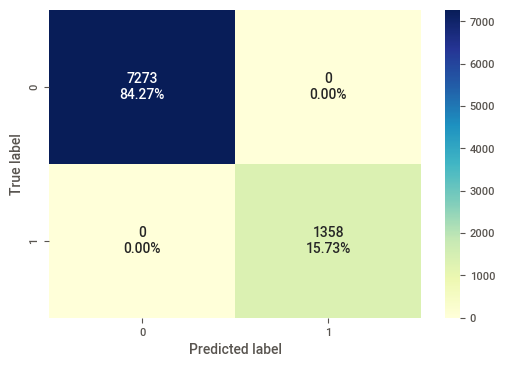

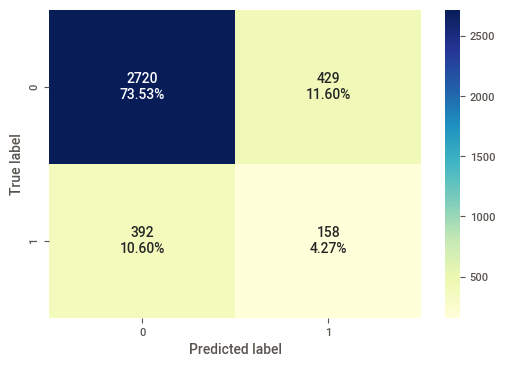

In [58]:
modelDT = DecisionTreeClassifier(
    criterion="gini", class_weight="balanced", random_state=1    #{0: 0.15, 1: 0.85}
)
modelDT.fit(X_train, y_train)

print("\033[1m" + "***ON TRAINING SET***" + "\033[0m")
evaluate_classifier(modelDT, y_train, X_train)
my_confusion_matrix(modelDT, y_train, X_train)

print("\033[1m" +"***ON TEST SET***"+ "\033[0m")
evaluate_classifier(modelDT, y_test, X_test) 
my_confusion_matrix(modelDT, y_test, X_test)


### The model is massively overfitting which is typical of decision trees

## Finding the best parameters for decision tree classifier

In [38]:
# Grid of parameters to choose from
estimator = DecisionTreeClassifier(random_state=1, class_weight="balanced")  #{0: 0.15, 1: 0.85}

parameters = {
    "max_depth": [3, 5, 10],
    # "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
    "max_features":[None, 'sqrt', 'log2'],
    "min_samples_split": [0.05, 0.1, 0.2]
}

# Type of scoring used to compare parameter combinations
# scorer = make_scorer(recall_score) 
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

grid_obj.best_params_


{'max_depth': 5,
 'max_features': None,
 'min_impurity_decrease': 1e-05,
 'min_samples_split': 0.2,
 'splitter': 'best'}

### Evaluate optimized estimator

***Training set***
Overall accuracy', 0.688
Precision: 0.294
Recall: 0.699
F1: 0.414
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      7273
           1       0.29      0.70      0.41      1358

    accuracy                           0.69      8631
   macro avg       0.61      0.69      0.60      8631
weighted avg       0.83      0.69      0.73      8631

***Test set***
Overall accuracy', 0.679
Precision: 0.274
Recall: 0.698
F1: 0.393
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.93      0.68      0.78      3149
           1       0.27      0.70      0.39       550

    accuracy                           0.68      3699
   macro avg       0.60      0.69      0.59      3699
weighted avg       0.83      0.68      0.72      3699



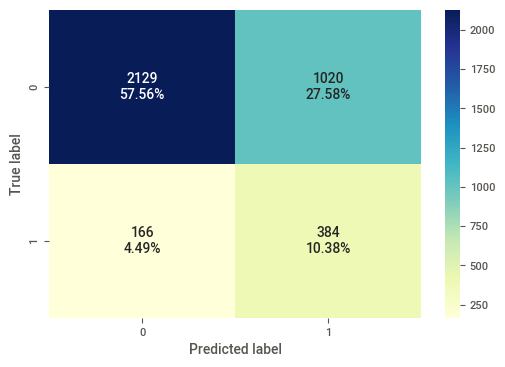

In [39]:
# Training set
print("***Training set***")
evaluate_classifier(estimator, y_train, X_train) 
# Test set
print("***Test set***")
evaluate_classifier(estimator, y_test, X_test) 
my_confusion_matrix(estimator, y_test, X_test)


### Visualizing tree

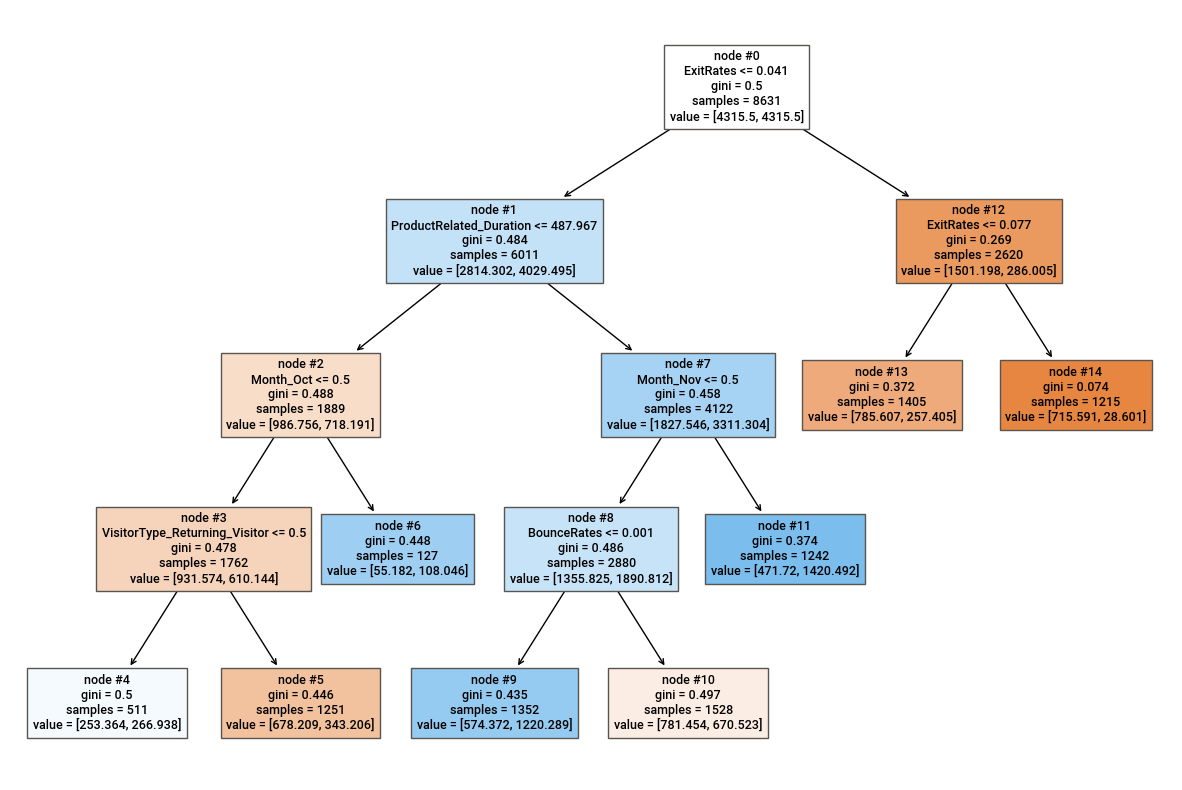

In [53]:
# Text report showing the rules of a decision tree -
# feature_names = X_train.columns.to_list()
# print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

# plt.savefig("C:/Users/Zohaib/repos/zohaibdr.github.io/images/shopping/decision_tree.png")

# Ensemble Methods: 
## Random Forests classifier 

In [45]:
modelRF = RandomForestClassifier(
    class_weight="balanced", random_state=10    #{0: 0.15, 1: 0.85}
)
parameters = {
    "n_estimators":[50,100,200],
    "max_depth": [3, 5, 7, None],
    # "criterion": ["entropy", "gini"],
    "min_impurity_decrease": [ 0.0001, 0.01],
    "min_samples_split": [.05, .1, .2],  #fraction of total samples 
    "max_features":[None, 'sqrt']
}

# Type of scoring used to compare parameter combinations
# scorer = make_scorer(recall_score) 
scorer = make_scorer(f1_score)


In [46]:
# Run the grid search
grid_obj = GridSearchCV(modelRF, parameters, scoring=scorer, cv=4, verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator2 = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator2.fit(X_train, y_train)

grid_obj.best_params_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=50; total time=   0.5s
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=50; total time=   0.6s
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=50; total time=   0.6s
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=50; total time=   0.5s
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=50; total time=   0.5s
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=100; total time=   1.1s
[CV] END max_depth=3, max_features=None, min_impurity_decrease=0.0001, min_samples_split=0.05, n_estimators=100; total time=   1.3s
[CV] END max_depth

{'max_depth': None,
 'max_features': None,
 'min_impurity_decrease': 0.0001,
 'min_samples_split': 0.05,
 'n_estimators': 50}

***ON TRAINING SET***
Overall accuracy', 0.718
Precision: 0.327
Recall: 0.750
F1: 0.456
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      7273
           1       0.33      0.75      0.46      1358

    accuracy                           0.72      8631
   macro avg       0.63      0.73      0.63      8631
weighted avg       0.84      0.72      0.75      8631

***ON TEST SET***
Overall accuracy', 0.705
Precision: 0.295
Recall: 0.707
F1: 0.416
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      3149
           1       0.29      0.71      0.42       550

    accuracy                           0.70      3699
   macro avg       0.61      0.71      0.61      3699
weighted avg       0.84      0.70      0.75      3699



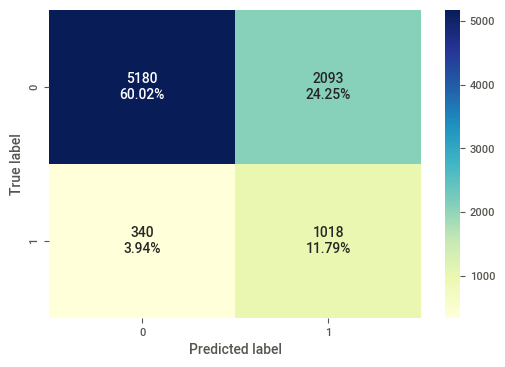

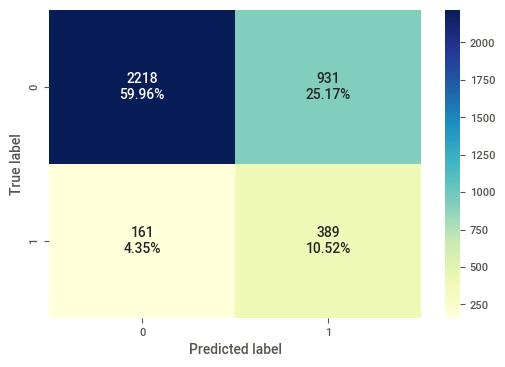

In [48]:
# Evaluating Random forests 

print("\033[1m" + "***ON TRAINING SET***" + "\033[0m")
evaluate_classifier(estimator2, y_train, X_train)
my_confusion_matrix(estimator2, y_train, X_train)

print("\033[1m" +"***ON TEST SET***"+ "\033[0m")
evaluate_classifier(estimator2, y_test, X_test) 
my_confusion_matrix(estimator2, y_test, X_test)


# Boosting algorithms



In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

GBoost = GradientBoostingClassifier(random_state=10). fit(X_train, y_train) 
AdaBoost = AdaBoostClassifier(random_state=10). fit(X_train, y_train) 
XGBoost = XGBClassifier(random_state=10). fit(X_train, y_train) 


In [12]:
names = ['Gradient Boost', 'AdaBoost', 'XGBoost']

# results = [[recall_score(y_train, GBoost.predict(X_train)),  recall_score(y_test, GBoost.predict(X_test))],
#         [recall_score(y_train, AdaBoost.predict(X_train)),  recall_score(y_test, AdaBoost.predict(X_test))],
#         [recall_score(y_train, XGBoost.predict(X_train)),  recall_score(y_test, XGBoost.predict(X_test))]
# ]

results = [[f1_score(y_train, GBoost.predict(X_train)),  f1_score(y_test, GBoost.predict(X_test))],
        [f1_score(y_train, AdaBoost.predict(X_train)),  f1_score(y_test, AdaBoost.predict(X_test))],
        [f1_score(y_train, XGBoost.predict(X_train)),  f1_score(y_test, XGBoost.predict(X_test))]
]

results = [[round(num,2) for num in mylist] for mylist in results] 
# print(results)

nPlusr = list(zip(names, results))  #create a list of tuples 

from tabulate import tabulate
print("***Boosting Methods***")
print(tabulate(nPlusr, headers = ['Algorithm','Score \n [Train, Test]'], tablefmt='pretty'))



***Boosting Methods***
+----------------+----------------+
|   Algorithm    |     Score      |
|                |  [Train, Test] |
+----------------+----------------+
| Gradient Boost |  [0.2, 0.12]   |
|    AdaBoost    |  [0.13, 0.14]  |
|    XGBoost     |  [0.81, 0.25]  |
+----------------+----------------+


## Hyperparameter optimization of boosting algorithms

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

Ada = AdaBoostClassifier(random_state=10)
GB = GradientBoostingClassifier(random_state=10)
XGBoost = XGBClassifier(random_state=10)

param1 = {}  #Ada Boost
param1['classifier'] = [Ada]
param1['classifier__n_estimators'] = [50, 100, 200]


param2 = {}  #Gradient Boost
param2['classifier'] = [GB]
# param2['classifier__max_depth'] = np.arange(2,7) 
# param2['classifier__n_estimators'] = [50, 100, 200]  
# param2['classifier__criterion']= ['friedman_mse','squared_error', 'mse'] 
param2['classifier__min_samples_split']= np.arange(1, 500, 100)
# param2['classifier__min_samples_leaf']= np.arange(1, 500, 100)
# param2['classifier__min_impurity_decrease'] = [0, 0.001, 0.002]
# param2['classifier__max_features'] = [0.6,0.8,"auto","sqrt"]


param3 = {} #XG Boost 
param3['classifier'] = [XGBoost]
param3['classifier__max_depth'] = np.arange(2,8,2) 
# param3['classifier__booster'] = ['gbtree', 'dart']
# param3['classifier__eta'] = np.arange(0.1, 0.7, 0.2)  #learning rate, default is 0.3

# param3['classifier__lambda'] = np.arange(0,20,4)  #eq. to L2 regularization para 
param3['classifier__alpha'] = np.arange(0,20,4)  #eq. to L1 regularization para 
param3['classifier__gamma'] = np.arange(0, 10, 2) #min loss reduction, increasing prevents overfitting

param3['classifier__min_child_weight'] = np.arange(1,9,2) 
param3['classifier__sub_sample'] = np.arange(0,0.2,0.8) 


pipeline = Pipeline([('classifier', Ada)])

params = [param1, param2, param3]
# print(params)
# print('*' * 80)

# define possible scoring matrix, then select the one in the 'refit' argument 
scoring = {'precision': make_scorer(precision_score, average = 'binary'),  
           'recall': make_scorer(recall_score, average = 'binary'),
           'f1': make_scorer(f1_score, average = 'binary')}
# 'binary':Only report results for the class specified by 'pos_label'in case of binary classif. 
# default val. of 'pos_label' = 1, so I am focusing on positive class prediction here, that is how well can I predict the customers who actually make a purchase. 

# or keep it simple
scoring = make_scorer(f1_score, average = 'binary')

grid = GridSearchCV(pipeline, params, cv=4, scoring = scoring, n_jobs= -1, verbose = 1, refit =True,    return_train_score=True) 

# grid = RandomizedSearchCV(pipeline, params, cv=4, scoring = scoring, n_jobs= -1, verbose = 2, refit ='recall', return_train_score=True, n_iter = 20, random_state=10) 

# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run in parallel to optimize the Search


In [20]:
#Here we fit all the 'different' models on the data provided. Takes time. 
grid.fit(X_train, y_train)   

# print best parameter after tuning
print(grid.best_estimator_)
print('The designated score of the best estimator is: %0.3f' %grid.best_score_) 


Fitting 4 folds for each of 308 candidates, totalling 1232 fits
[18:22:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Pipeline(steps=[('classifier',
                 XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                               callbacks=None, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
     

In [21]:
# see all the cominations used by the Search
CVresults = pd.DataFrame(grid.cv_results_)
# index of the best result  
best_row = grid.best_index_
print(best_row)

# best_f1 = grid.cv_results_['mean_test_f1'][best_row]
# best_precision = grid.cv_results_['mean_test_precision'][best_row]
# best_recall = grid.cv_results_['mean_test_recall'][best_row]

# print('Best_F1score: %.3f' %best_f1)
# print('Best_Precision: %.3f' %best_precision)
# print('Best_Recall: %.3f' %best_recall)

18


[18:25:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sub_sample" } are not used.

***ON TRAINING SET***
Overall accuracy', 0.920
Precision: 0.945
Recall: 0.524
F1: 0.674
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7273
           1       0.95      0.52      0.67      1358

    accuracy                           0.92      8631
   macro avg       0.93      0.76      0.81      8631
weighted avg       0.92      0.92      0.91      8631

***ON TEST SET***
Overall accuracy', 0.844
Precision: 0.447
Recall: 0.198
F1: 0.275
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3149
           1       0.45      0.20      0.27       550

    accuracy                           0.84      3699
   macro avg       0.66      0.58      

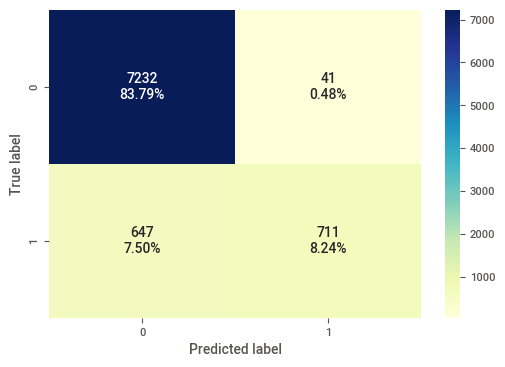

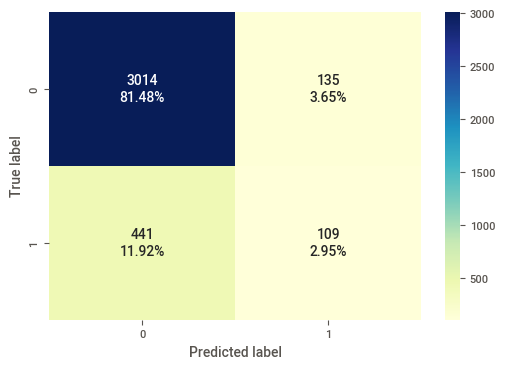

In [22]:
# Set the clf to the best combination of parameters
optimEstimator = grid.best_estimator_

# Fit the best algorithm to the data.
optimEstimatorFIT = optimEstimator.fit(X_train, y_train)


print("***ON TRAINING SET***")
evaluate_classifier(optimEstimatorFIT, y_train, X_train)
my_confusion_matrix(optimEstimatorFIT, y_train, X_train)

print("***ON TEST SET***")
evaluate_classifier(optimEstimatorFIT, y_test, X_test) 
my_confusion_matrix(optimEstimatorFIT, y_test, X_test)



The performance is not great on test set. 
We can furhter reduce overfitting by manually adjusting the hyperparameters

***ON TRAINING SET***
Overall accuracy', 0.963
Precision: 0.969
Recall: 0.789
F1: 0.870
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7273
           1       0.97      0.79      0.87      1358

    accuracy                           0.96      8631
   macro avg       0.97      0.89      0.92      8631
weighted avg       0.96      0.96      0.96      8631

***ON TEST SET***
Overall accuracy', 0.824
Precision: 0.361
Recall: 0.240
F1: 0.288
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3149
           1       0.36      0.24      0.29       550

    accuracy                           0.82      3699
   macro avg       0.62      0.58      0.59      3699
weighted avg       0.80      0.82      0.81      3699



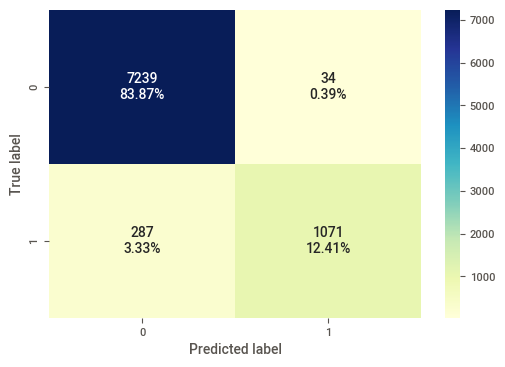

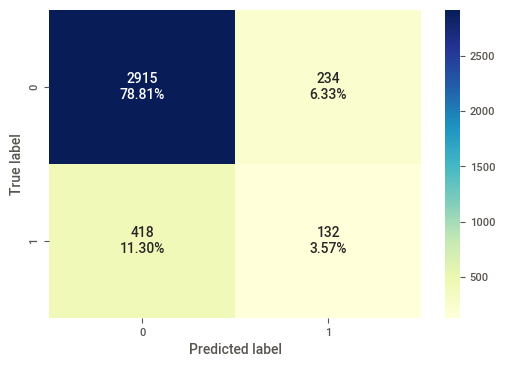

In [77]:
estimator3 = XGBClassifier(alpha=2, gamma=0, learning_rate=0.9, max_depth=5, 
                                base_score=0.5, booster='gbtree',
                               callbacks=None, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_leaves=0,
                               min_child_weight=5, 
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1).fit(X_train, y_train)



print("***ON TRAINING SET***")
evaluate_classifier(estimator3, y_train, X_train)
my_confusion_matrix(estimator3, y_train, X_train)

print("***ON TEST SET***")
evaluate_classifier(estimator3, y_test, X_test) 
my_confusion_matrix(estimator3, y_test, X_test)

## Exploring Final model results 

<AxesSubplot: title={'center': 'Feature importance from XGBoost classifier'}, xlabel='F score', ylabel='Features'>

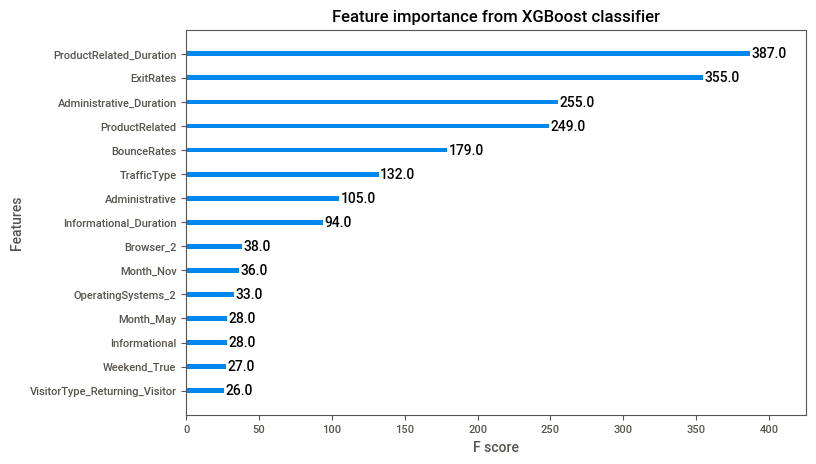

In [70]:
from xgboost import plot_importance, plot_tree
import graphviz
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 8,5
plot_importance(estimator3, max_num_features=15, grid=False, title="Feature importance from XGBoost classifier")

# explanation here: https://notebook.community/minesh1291/MachineLearning/xgboost/feature_importance_v1

# plt.savefig("C:/Users/Zohaib/repos/zohaibdr.github.io/images/shopping/feature_imp.png")


The F-Score method is a filter feature selection method that looks at the relationship between each descriptive feature and the target feature using the F-distribution. 

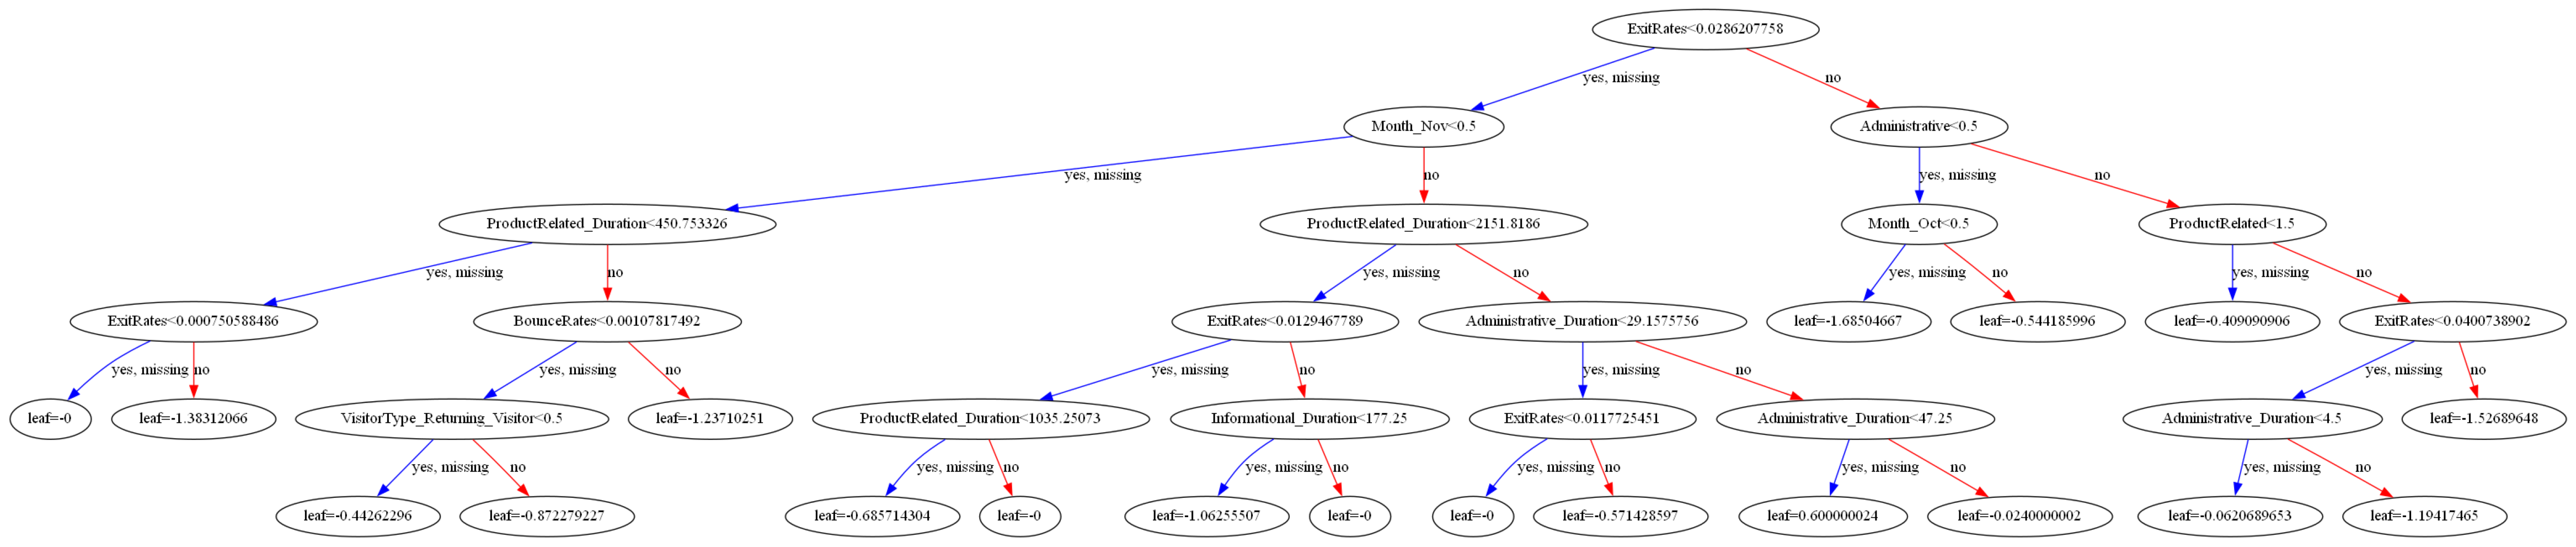

In [71]:
# Plot final tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
rcParams['figure.figsize'] = 60,60
plot_tree(estimator3)

# plt.savefig("C:/Users/Zohaib/repos/zohaibdr.github.io/images/shopping/XGBtree.png")
